In [1]:
import numpy as np
from neuralStellar import *
import pymc3 as pm
import corner
import seaborn as sns
import theano.tensor as T
import os

In [22]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['L','Teff','delnu'])
m1.loadModel('Ran_files/small_grid_28/small_grid_model.h5')
m1.getWeights()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512 

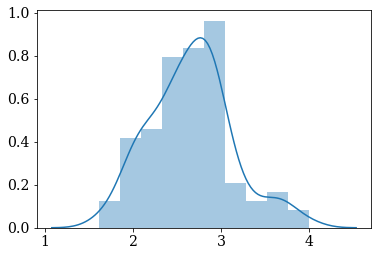

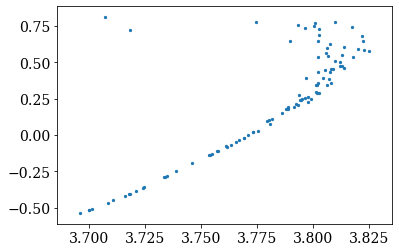

In [29]:
data = np.load('pymc3_traces/NNcluster2/cluster_data.npy')
[Tmass, Tage] = data
N=len(Tmass)
sns.distplot(Tage)
plt.show()
Tfeh = np.zeros(N)
TMLT = np.ones(N)*1.9

Tinputs = np.log10(np.vstack((Tmass, Tage, 10**Tfeh, 10**TMLT)))
Toutputs = m1.model.predict(Tinputs.T).T
[TL, TTeff, Tdelnu] = 10**Toutputs
plt.scatter(np.log10(TTeff), np.log10(TL), s=5)
plt.show()

In [8]:
model = pm.Model()
with model:
    Age_mu = pm.Normal('mean_age', 3, 0.7)
    Age_sigma = pm.Lognormal('spread_age', T.log(0.5), 0.5)
    Age = pm.Normal('age', Age_mu, Age_sigma, shape=N)
    M = pm.Deterministic('mass', pm.Beta('c',1.1,1.1,shape=N)*(1.44-0.8)+0.8)
    feh = pm.Deterministic('feh', T.zeros(N))
    MLT = pm.Deterministic('MLT',T.ones(N)*1.9)
    
    obs = pm.Deterministic('obs',m1.manualPredict([T.log10(M), T.log10(Age), feh, MLT]))
    
    obs_L = pm.Normal('obs_L',10**obs[0,:],0.1, observed=TL)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1,:],70, observed=TTeff)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2,:],0.1, observed=Tdelnu)

In [9]:
trace = pm.load_trace(directory='pymc3_traces/NNcluster2', model=model)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B425784DD8>,
      dtype=object)

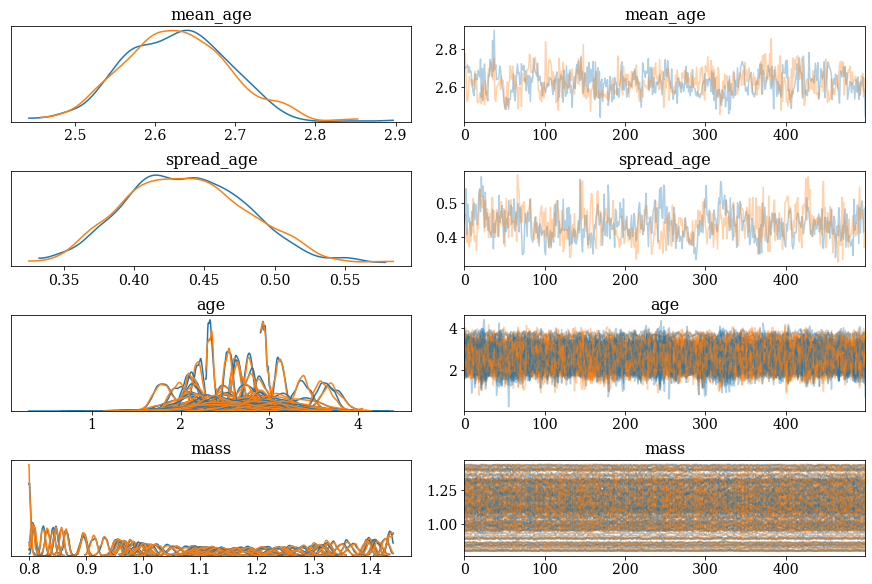

In [10]:
pm.plots.traceplot(trace,var_names=['mean_age','spread_age','age','mass'],compact=True)

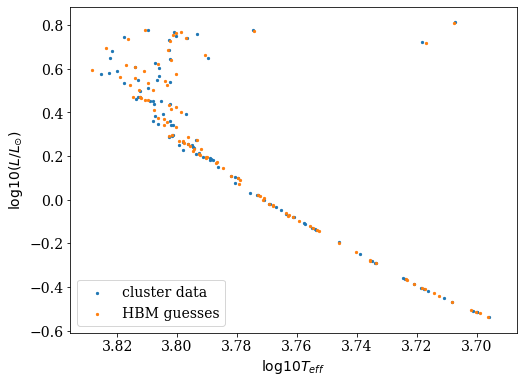

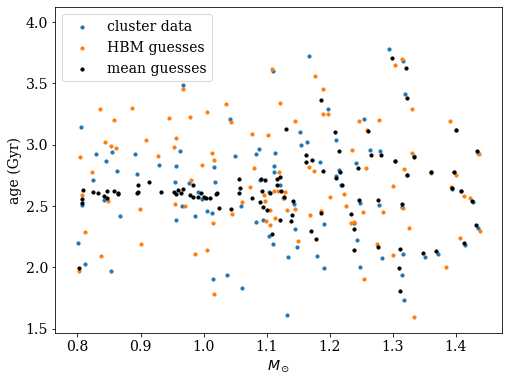

In [30]:
from matplotlib import rc
rc("font", family="serif", size=14)
pop1_ages=trace['age'][0]
pop1_masses = trace['mass'][0]
Finputs = np.log10(np.vstack((pop1_masses, pop1_ages, 10**Tfeh, 10**TMLT)))
Foutputs = m1.model.predict(Finputs.T).T
[FL, FTeff, Fdelnu] = 10**Foutputs
fig, ax=plt.subplots(1,1,figsize=[8,6])
ax.scatter(np.log10(TTeff), np.log10(TL), s=5, label='cluster data')
ax.scatter(np.log10(FTeff), np.log10(FL), s=5, label='HBM guesses')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
ax.legend()
plt.show()

fig, ax=plt.subplots(1,1,figsize=[8,6])
ax.scatter(Tmass, Tage,s=10, label='cluster data')
ax.scatter(pop1_masses, pop1_ages, s=10, label='HBM guesses')
ax.scatter(np.mean(trace['mass'],axis=0), np.mean(trace['age'],axis=0),s=10,color='black', label='mean guesses')
ax.set_xlabel(r'$M_\odot$')
ax.set_ylabel(r'age (Gyr)')
ax.legend()
plt.show()

In [32]:
pm.summary(trace, var_names=['mean_age','spread_age','age','mass'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_age,2.626,0.064,2.520,2.752,0.004,0.003,283.0,283.0,285.0,453.0,1.00
spread_age,0.438,0.045,0.356,0.521,0.003,0.002,224.0,220.0,232.0,459.0,1.00
age[0],2.608,0.347,1.947,3.243,0.013,0.009,678.0,673.0,673.0,616.0,1.00
age[1],2.292,0.274,1.782,2.766,0.013,0.009,464.0,462.0,459.0,552.0,1.01
age[2],2.564,0.380,1.891,3.326,0.016,0.012,533.0,533.0,535.0,659.0,1.00
age[3],2.674,0.437,1.886,3.454,0.023,0.016,377.0,373.0,375.0,491.0,1.00
age[4],2.643,0.393,1.973,3.400,0.018,0.013,454.0,454.0,464.0,497.0,1.00
age[5],2.602,0.438,1.741,3.401,0.019,0.014,506.0,486.0,501.0,634.0,1.00
age[6],2.616,0.427,1.806,3.369,0.022,0.015,384.0,384.0,385.0,516.0,1.00
age[7],2.472,0.407,1.738,3.258,0.021,0.015,373.0,370.0,381.0,422.0,1.00


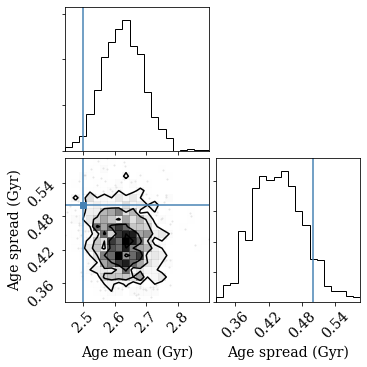

In [33]:
corner.corner(np.array([trace['mean_age'], trace['spread_age']]).T, truths=[2.5,0.5], labels=['Age mean (Gyr)','Age spread (Gyr)']);

Text(0, 0.5, 'std age (Gyr)')

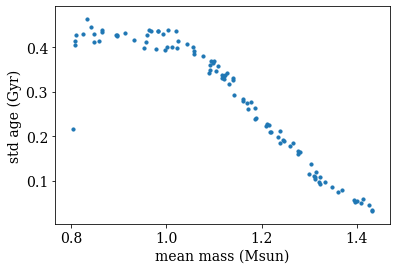

In [36]:
plt.scatter(np.mean(trace['mass'],axis=0),np.std(trace['age'],axis=0),s=10)
plt.xlabel('mean mass (Msun)')
plt.ylabel('std age (Gyr)')